In [18]:
import pandas as pd
import numpy as np
import urllib
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

## Data Fetching
We're sending a get request to the link to collect the data that we will be using

In [19]:
download_link = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-020-0684-z/MediaObjects/41587_2020_684_MOESM2_ESM.xlsx"
urllib.request.urlretrieve(download_link, "../data/covid_time_series.xls")

('../data/covid_time_series.xls', <http.client.HTTPMessage at 0x1a21ea0c88>)

## Data Cleaning/Transforming
Set types, clean column names, remove faulty formatting, discarding unused columns, and set the correct date

In [23]:
pd.read_excel("../data/covid_time_series.xls")

Figure 2 COVID-19 Epidemiological Data  \
NaN    NaN                                                                  NaN   
       Number of positive tests by date                  Percentage of positive   
Date   of specimen collection                                  tests by date of   
NaN    NaN                                                  specimen collection   
       Figure 2 a,b                                                Figure 2 c,d   
19-Mar 10                                                               21.2766   
20-Mar 5                                                                 15.625   
21-Mar 11                                                               47.8261   
22-Mar 10                                                               20.8333   
23-Mar 25                                                               18.3206   
24-Mar 39                                                               22.2857   
25-Mar 32                                                               21.0884   
26-Mar 35                                                               23.9726   
27-Mar 55                                                               29.1892   
28-Mar 42                                                               35.7724   
29-Mar 32                                                               57.1429   
30-Mar 63                                                               52.1008   
31-Mar 65                                                                  43.8   
1-Apr  100                                                              54.8387   
2-Apr  74                                                               55.1471   
3-Apr  81                                                                47.929   
4-Apr  77                                                               61.7886   
5-Apr  44                                                               38.5965   
6-Apr  110                                                              50.9524   
7-Apr  73                                                               49.3151   
8-Apr  104                                                              53.9267   
9-Apr  96                                                               62.1795   
10-Apr 81                                                                50.625   
11-Apr 62                                                               54.0541   
12-Apr 34                                                               34.6535   
...                                                                         ...   
3-May  34                                                               19.6532   
4-May  76                                                               28.9575   
5-May  62                                                               18.6782   
6-May  67                                                               16.7539   
7-May  41                                                               13.0137   
8-May  51                                                               12.1588   
9-May  25                                                               11.7647   
10-May 19                                                                  14.4   
11-May 57                                                               16.4384   
12-May 34                                                                8.4142   
13-May 36                                                                8.1395   
14-May 70                                                               14.0271   
15-May 41                                                                9.7345   
16-May 20                                                                7.1429   
17-May 13                                                                9.8266   
18-May 35                                                                9.4188   
19-May 20                                                

In [17]:
col_names = ["Date","cases_specimen","percent","admits","cases_reported"]
astypes = {"cases_specimen": "float", 'case_reported': "float"}
covid_series = pd.read_excel("../data/covid_time_series.xls", names=col_names, astype=astypes)

covid_series = covid_series[5:].dropna().drop(["percent","admits"],axis=1).reset_index(drop=True) # remove the shitty data
covid_series["Date"] = pd.to_datetime(covid_series["Date"] + '-2020') # conversion to 2020 date

ValueError: Length mismatch: Expected axis has 3 elements, new values have 5 elements

In [4]:
covid_series

,Date,cases_specimen,cases_reported
0,2020-03-19,10,1
1,2020-03-20,5,2
2,2020-03-21,11,1
3,2020-03-22,10,4
4,2020-03-23,25,5
...,...,...,...
69,2020-05-28,22,15
70,2020-05-29,12,25
71,2020-05-30,12,7
72,2020-05-31,5,58


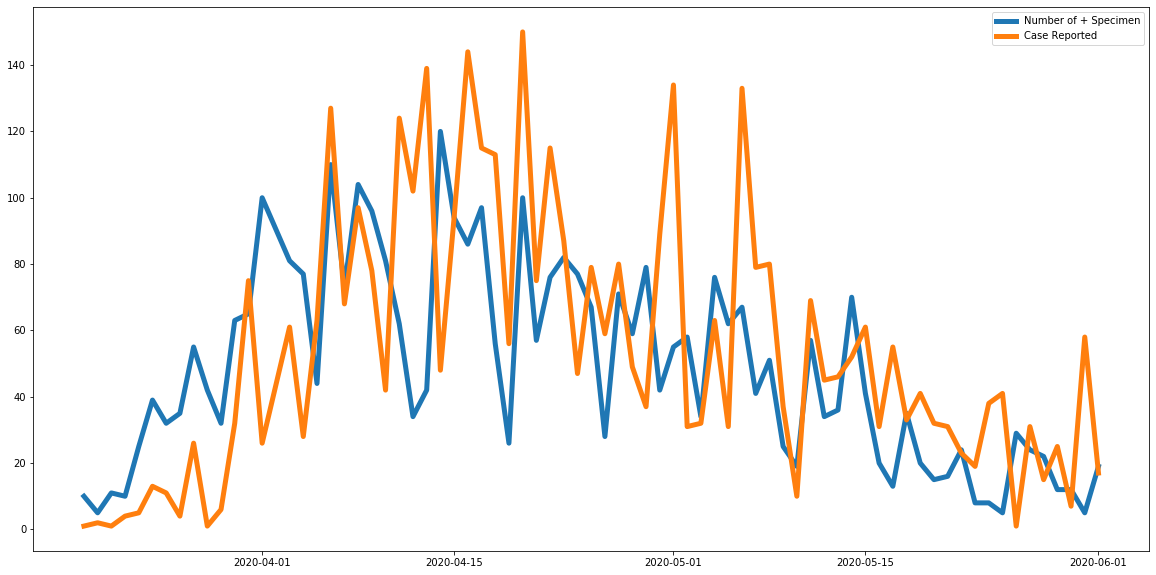

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(covid_series["Date"], covid_series["cases_specimen"], linewidth=5, label="Number of + Specimen")
plt.plot(covid_series["Date"], covid_series["cases_reported"], linewidth=5, label="Case Reported")
plt.legend()
plt.show()

## Correlation Without Offset

### Pearson

In [6]:
no_offset_r = pearsonr(covid_series["cases_reported"], covid_series["cases_specimen"])[0]

### Spearsman

In [7]:
no_offset_s = spearmanr(covid_series["cases_specimen"], covid_series["cases_reported"])[0]

In [8]:
# Baseline Loss: The lower the better the offset
1 / (no_offset_r * no_offset_s)

2.9147299893140333

## Correlation With Offset cases report -5 days

In [9]:
covid_series_neg5 = covid_series.copy()
covid_series_neg5["cases_reported"] = covid_series_neg5["cases_reported"].shift(-5)
covid_series_neg5 = covid_series_neg5.dropna()

In [10]:
len(covid_series_neg5)

69

## The I hope this works model
Based off a linear matrix transformation to find optimal offset w/ pseudo derivative (from the limit approach) of loss_ps

$$
\begin{bmatrix} 
x_1 \\
x_2 \\
\end{bmatrix} * 
\begin{bmatrix} 
m_{11} & m_{12} \\
m_{21} & m_{22} \\
\end{bmatrix}
+ 
\begin{bmatrix} 
b_1 \\
b_2 \\
\end{bmatrix}
$$

In [11]:
predictor = np.array([[x1, x2] for x1, x2 in covid_series["cases_specimen"].iteritems()])
response = np.array([[x2, x2] for x1, x2 in covid_series["cases_reported"].iteritems()])

In [12]:
def loss_p(x1, x2):
    return (1 / pearsonr(x1, x2)[0])**2
def loss_s(x1, x2):
    return (1 / spearmanr(x1, x2)[0])**2
def loss_ps(x1, x2):
    return (1 / (pearsonr(x1, x2)[0] * spearmanr(x1, x2)[0]))**2
def pseudo_deriv(h, loss_f, respect):
    """
    https://mathinsight.org/partial_derivative_limit_definition
    """
    return (loss_f(h+respect[:, 0], respect[:, 1]) - loss_f(respect[:, 0], respect[:, 1])) / h

def transform(x, M, b):
    return np.matmul(x, M) + b

# Problems: Not derivable + limit definition returns 0

In [13]:
M = np.random.random((2, 2))
b = np.random.random(2)

## I hope this works model take two
Where offset is controlled by the day (bias), also parameterized by a linear verticle transformation

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
predictor = np.array(covid_series["cases_specimen"], dtype=float).reshape(-1,1)
response = np.array(covid_series["cases_reported"], dtype=float).reshape(-1,1)

In [16]:
def MSE(x1, x2):
    return np.mean((x1-x2)**2)
def linear_reg(X, y, offset):
    X = np.append(X, np.ones((len(X), 1)), axis=1)
    return np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
def transform(X, y, offset):
    coef = linear_reg(X, y, offset)
    return X * coef[0][0] + coef[1][0]

In [17]:
transformed_X = transform(predictor, response, 0)

fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(covid_series["Date"], covid_series["cases_specimen"], linewidth=5, label="Number of + Specimen")
plt.plot(covid_series.Date, transformed_X, label="Transformed")
plt.plot(covid_series["Date"], covid_series["cases_reported"], linewidth=5, label="Case Reported")
plt.legend()
plt.show()

In [18]:
loss_p(transformed_X.flatten(), response.flatten())

3.044582712121405

In [19]:
loss_p(predictor.flatten(), response.flatten())

3.0445827121214046

Turns, out pearsor isn't impacted by linear transformation 

# I'm slightly slow
Attempt three, only shift day

In [20]:
X = covid_series["cases_specimen"]
y = covid_series["cases_reported"]

In [25]:
def offset(X, y, offset, f):
    if offset >= 0:
        return f(X.shift(offset)[offset:], y[offset:])
    return f(X.shift(offset)[:offset], y[:offset])

In [26]:
for i in range(-14, 16):
    print(f"Offset: {i}. \n\tSpearman/Pearson Loss Score: {round(offset(X, y, i, loss_ps), 2)}\n\tPearson Loss Score: {round(offset(X, y, i, loss_p), 2)}\n\tSpearman Loss Score: {round(offset(X, y, i, loss_s), 2)}")

Offset: -15. 
	Spearman/Pearson Loss Score: 954.39
	Pearson Loss Score: 26.0
	Spearman Loss Score: 36.7
Offset: -14. 
	Spearman/Pearson Loss Score: 14106324.78
	Pearson Loss Score: 11032.67
	Spearman Loss Score: 1278.6
Offset: -13. 
	Spearman/Pearson Loss Score: 1923.89
	Pearson Loss Score: 49.7
	Spearman Loss Score: 38.71
Offset: -12. 
	Spearman/Pearson Loss Score: 9891.13
	Pearson Loss Score: 140.53
	Spearman Loss Score: 70.38
Offset: -11. 
	Spearman/Pearson Loss Score: 486135.38
	Pearson Loss Score: 1566.12
	Spearman Loss Score: 310.41
Offset: -10. 
	Spearman/Pearson Loss Score: 30201.31
	Pearson Loss Score: 171.05
	Spearman Loss Score: 176.57
Offset: -9. 
	Spearman/Pearson Loss Score: 7672.93
	Pearson Loss Score: 62.43
	Spearman Loss Score: 122.9
Offset: -8. 
	Spearman/Pearson Loss Score: 2917.62
	Pearson Loss Score: 50.06
	Spearman Loss Score: 58.28
Offset: -7. 
	Spearman/Pearson Loss Score: 271.8
	Pearson Loss Score: 16.88
	Spearman Loss Score: 16.1
Offset: -6. 
	Spearman/Pearson

Looks like an offset of 2, 3, and 7 days are optimal

Lowest Spearman: 3

Lowest Pearson: 2

In [27]:
offset = 2
pearsonr(X.shift(offset)[offset:], y[offset:])

(0.6317719087881046, 2.6655821736107895e-09)

In [29]:
offset = 3
spearmanr(X.shift(offset)[offset:], y[offset:])

SpearmanrResult(correlation=0.6623385361330311, pvalue=3.160708754198832e-10)

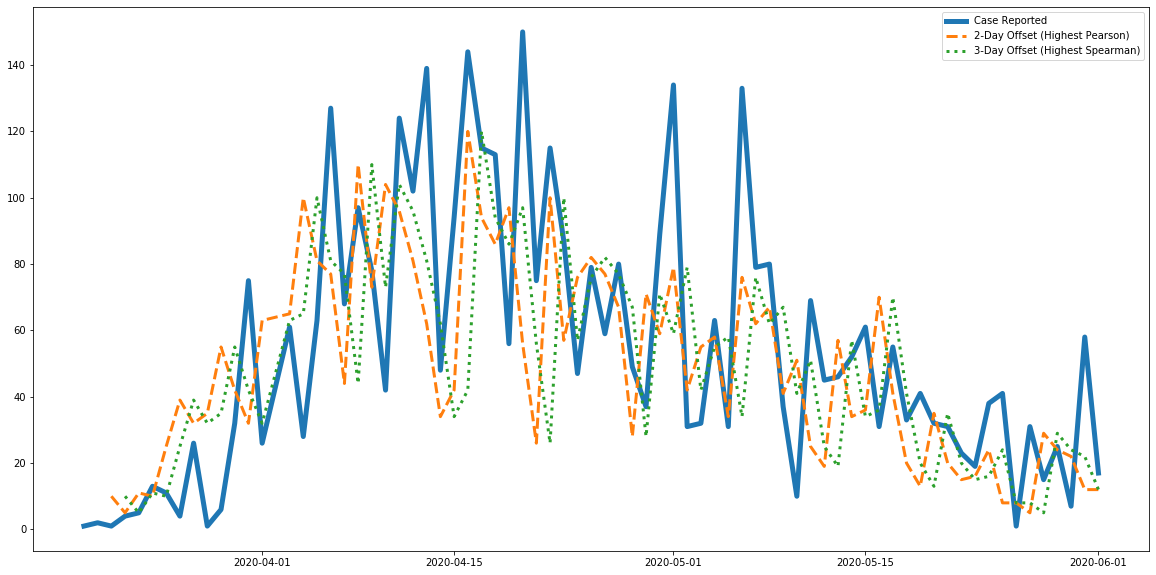

In [40]:
fig, ax = plt.subplots(figsize=(20, 10))
#plt.plot(covid_series["Date"], covid_series["cases_specimen"], linewidth=1, label="Number of + Specimen (No Offset)")
plt.plot(covid_series["Date"], covid_series["cases_reported"], linewidth=5, label="Case Reported")
plt.plot(covid_series["Date"], covid_series["cases_specimen"].shift(2), linestyle="--", linewidth=3, label="2-Day Offset (Highest Pearson)")
plt.plot(covid_series["Date"], covid_series["cases_specimen"].shift(3), linestyle=":", linewidth=3, label="3-Day Offset (Highest Spearman)")
plt.legend()
plt.show()